In [23]:
# %pip install -U pip datasets ipywidgets
# For mac OS
# %pip install -U tensorflow==2.16.2 tensorflow-macos==2.16.2 keras==3.4.1 keras-nlp
# 20240803, tensorflow-text can be installed on Apple Silicon mac now!
# %pip install tensorflow-text
# For Intel mac
# %pip install -U tensorflow==2.16.2 tensorflow-text keras==3.4.1 keras-nlp
# For AWS SageMaker
# %pip install -U tensorflow==2.16.2 tensorflow-datasets tensorflow-text keras==3.4.1 keras-nlp datasets rouge-score py7zr

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 754.8 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.1/236.1 MB 2.1 MB/s eta 0:00:0000:0100:03m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 1.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.2
    Uninstalling tensorflow-2.16.2:
      Successfully uninstalled tensorflow-2.16.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-macos 2.16.2 requires ten

In [1]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [2]:
# Utility function to determine where this note is running
import platform

def is_running_on_apple_silicon():
    return platform.system() == "Darwin" and platform.processor() == "arm"

def is_running_on_intel_mac():
    return platform.system() == "Darwin" and platform.processor() == "i386"

DEVELOPMENT = is_running_on_apple_silicon()
DEVELOPMENT = False
DEBUGGER_V2 = False

In [3]:
import tensorflow as tf
import keras
import keras_nlp
print("Tensorflow 2.16.2 is expected. The running version is", tf.__version__)
print("Keras 3.4.1 is expected. The running version is", keras.__version__)
print("KerasNLP 0.12.1 is expected. The running version is", keras_nlp.__version__)

if is_running_on_apple_silicon() or is_running_on_intel_mac():
    FLOAT_TYPE = tf.float32
else:
    """
    # Mixed-precision training
    Deep Learning with Python, Second Edition
    François Chollet

    However, this makes the processing 2.x slower on M2 Apple Silicon.

    Machine | 1 step
    --- | ---
    Intel Mac fp16 | 12s
    Intel Mac fp32 | 7s
    Apple Silicon Mac fp16 | 1.8s
    Apple Silicon Mac fp32 | 640ms
    ml.p3.2xlarge | 166ms
    """
    keras.mixed_precision.set_global_policy("mixed_float16")
    FLOAT_TYPE = tf.float16

import numpy as np
import tensorflow_datasets as tfds
# SageMaker cannot use @keras.saving
from keras import saving
import datetime

Tensorflow 2.16.2 is expected. The running version is 2.17.0
Keras 3.4.1 is expected. The running version is 3.4.1
KerasNLP 0.12.1 is expected. The running version is 0.12.1


# Utility function

In [4]:
import matplotlib.pyplot as plt

def plot(history, title=None, keys=["loss", "masked_acc"]):
    """
    Display the plot that indicates the loss and accuracy.
    :param history: history object from the tensorflow fit function.
    :param title: title text.
    :param keys: keys for plotting.
    """
    for key in keys:
        if 'loss' in key:
            print(
                np.min(history.history[f"val_{key}"]),
                "The best number of epocs for the validation loss is",
                np.argmin(history.history[f"val_{key}"]) + 1,
            )
        else:
            print(
                np.max(history.history[f"val_{key}"]),
                "The best number of epocs for the validation accuracy is",
                np.argmax(history.history[f"val_{key}"]) + 1,
            )

    flg, axes = plt.subplots(1, 2, tight_layout=True)
    if title is not None:
        flg.suptitle(t=title, fontsize=14)
    for i, key in enumerate(keys):
        value = history.history[key]
        val_loss = history.history[f"val_{key}"]
        epochs = range(1, len(value) + 1)
        axes[i].plot(epochs, value, label=f"Training {key}")
        axes[i].plot(epochs, val_loss, label=f"Validation {key}")
        axes[i].set_title(f"Training and validation {key}")
        axes[i].set_xlabel("epochs")
        axes[i].set_ylabel(key)
        axes[i].legend()
    plt.show()


In [5]:
def plot_model(model, custom_objects={}):
    if isinstance(model, str):
        model = keras.models.load_model(
            model,
            custom_objects=custom_objects
        )
    keras.utils.plot_model(
        model,
        show_shapes=True,
        expand_nested=True
    )

In [6]:
def get_log_dir(now):
    log_dir = "logs/fit/" + now.strftime("%Y%m%d-%H%M%S")
    return log_dir

def get_tensorboard_callback(now):
    # @see https://www.tensorflow.org/tensorboard/get_started
    log_dir = get_log_dir(now=now)
    tensorboard_callback = keras.callbacks.TensorBoard(
        log_dir=log_dir,
        histogram_freq=1
    )
    return tensorboard_callback

In [7]:
def get_exponential_decay_learning_rate(initial_learning_rate, decay_steps, decay_rate):
    if decay_rate < 1.0:
        learning_rate = keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=decay_steps,
            decay_rate=decay_rate,
        )
        return learning_rate
    else:
        return initial_learning_rate

def get_default_optimizer(initial_learning_rate, decay_steps, decay_rate):
    learning_rate = get_exponential_decay_learning_rate(
        initial_learning_rate=initial_learning_rate,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
    )
    if f"{keras.__version__}".startswith("2.") and (is_running_on_apple_silicon() or is_running_on_intel_mac()):
        optimizer = keras.optimizers.legacy.Adam(
            learning_rate=learning_rate,
        )
    else:
        optimizer = keras.optimizers.Adam(
            learning_rate=learning_rate,
        )
    return optimizer


In [8]:
# @see https://keras.io/api/callbacks/reduce_lr_on_plateau/
reduce_lr_callbacks = keras.callbacks.ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_delta=0.04,
    cooldown=8,
    min_lr=2e-5, # 5e-4: 0.0005, 2e-5: 0.00002
)

In [9]:
"""
### The reason why the masked loss is required for seq2seq models

The prediction y values of seq2seq models contain pad(s), which are used to align the length of every output sequence.
In the case that most sequences are much shorter than the longest sentence and pads are not considered,
a model that predicts only pads of sentences is highly evaluated.
Therefore, excluding pads from the loss calculation improves the model.

### The reason why the classification model does not use the masked loss function

The prediction y values of classification models do not contain pad(s), which are used to align the length of every output sequence.
It just contains the probability of each class.
"""

# @see https://www.tensorflow.org/text/tutorials/nmt_with_attention
@saving.register_keras_serializable()
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = keras.losses.SparseCategoricalCrossentropy(
        # nn.py:609: UserWarning:
        # "`sparse_categorical_crossentropy` received `from_logits=True`,
        # but the `output` argument was produced by a Softmax activation and thus does not represent logits.
        # Was this intended?
        # When logits is True, softmax activation function has not processed the values.
        from_logits=True,
        reduction='none'
    )
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, dtype=loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [10]:
# @see https://www.tensorflow.org/text/tutorials/nmt_with_attention
# @saving.register_keras_serializable()
# def masked_acc(y_true, y_pred):
#     # Calculate the loss for each item in the batch.
#     y_pred = tf.argmax(y_pred, axis=-1) # last index
#     y_pred = tf.cast(y_pred, dtype=y_true.dtype)
#     match = tf.cast(y_true == y_pred, dtype=FLOAT_TYPE)
#     mask = tf.cast(y_true != 0, dtype=FLOAT_TYPE)
#     return tf.reduce_sum(match)/tf.reduce_sum(mask)

# @see https://www.tensorflow.org/text/tutorials/transformer
@saving.register_keras_serializable()
def masked_acc(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=2)
    y_true = tf.cast(y_true, dtype=y_pred.dtype)
    match = y_true == y_pred
    mask = y_true != 0
    match = match & mask
    match = tf.cast(match, dtype=FLOAT_TYPE)
    mask = tf.cast(mask, dtype=FLOAT_TYPE)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

## Dataset

In [11]:
import datasets

def prepare_datasets():
    # How to convert huggingface dataset to tensorflow dataset
    # @see https://huggingface.co/docs/datasets/v1.3.0/torch_tensorflow.html#setting-the-format
    def convert_hf2tf(
            dataset: datasets.DatasetDict,
            split: list[str],
            columns=['article', 'highlights', 'id',]):
        dataset.set_format(
            type='tensorflow',
            columns=columns
        )
        l = []
        for s in split:
            d = dataset[s]
            features = {x: d[x] for x in columns}
            # .batch(32) is not used to show a simple sampled data below with take(1)
            tf_dataset = tf.data.Dataset.from_tensor_slices(features)
            l.append(tf_dataset)
        return tuple(l)
    ds = datasets.load_dataset(
        'Samsung/samsum',
        trust_remote_code=True
    )
    train_ds, validation_ds, test_ds = convert_hf2tf(
        dataset=ds,
        split=['train', 'validation', 'test'],
        columns=['id', 'summary', 'dialogue'],
    )
    # for development with 1/10 entries
    if DEVELOPMENT:
        train_size = len(train_ds) // 100 * 90
        validation_size = len(validation_ds) // 100 * 90
        test_size = len(test_ds) // 100 * 90
        train_ds = train_ds.skip(train_size)
        validation_ds = validation_ds.skip(validation_size)
        test_ds = test_ds.skip(test_size)
    return train_ds, validation_ds, test_ds

# Prediction

In [13]:
def generate_text(
        model,
        input_text,
        max_length=64):
    output = model.generate(
        input_text,
        max_length=max_length
    )
    return output

def generate_prediction_result(bart_lm, ds, max_length):
    x = []
    y_true = []
    for row in ds:
        x.append(row["encoder_text"].numpy())
        y_true.append(row["decoder_text"].numpy())

    # Let's make a dummy call - the first call to XLA generally takes a bit longer.
    _ = generate_text(
        bart_lm,
        "sample text",
        max_length=max_length
    )

    y_pred = generate_text(
        bart_lm,
        ds.map(lambda row: row["encoder_text"]).batch(8),
        max_length=max_length,
    )
    return x, y_true, y_pred

def display_sampled_summary(x, y_true, y_pred, sample=5):
    for i in range(sample):
        print("text:", x[i])
        print("y_true:", y_true[i])
        print("y_pred:", y_pred[i])
        print("=============================")

def calculate_rouge_score(y_true, y_pred):
    rouge_n = keras_nlp.metrics.RougeN(order=2)
    rouge_2_score = rouge_n(y_true, y_pred)
    rouge_n = keras_nlp.metrics.RougeN(order=1)
    rouge_1_score = rouge_n(y_true, y_pred)
    rouge_l = keras_nlp.metrics.RougeL()
    rouge_l_score = rouge_l(y_true, y_pred)
    return rouge_1_score, rouge_2_score, rouge_l_score

## Model and Training

In [12]:
class RougeEvaluator(keras.callbacks.Callback):
    def __init__(
            self,
            dataset,
            max_length):
        self.dataset = dataset
        self.max_length = max_length
  
    def on_epoch_end(self, epoch, logs=None):
        _, y_true, y_pred = generate_prediction_result(
            bart_lm=self.model,
            ds=self.dataset,
            max_length=self.max_length
        )
        rouge_1_score, rouge_2_score, rouge_l_score = calculate_rouge_score(
            y_true=y_true,
            y_pred=y_pred
        )
        print(rouge_1_score)
        print(rouge_2_score)
        print(rouge_l_score)

def format_dataset_bart_seq2seq(row):
    return {
        "encoder_text": row["dialogue"],
        "decoder_text": row["summary"]
    }
    
def build_bart_model(
    training_data,
    validation_data,
    encoder_sequence_length=128,  # 128: 75% covered. max is 803.
    decoder_sequence_length=64,  # 32: 75% covered. max is 64
    learning_rate=5e-5,
    weight_decay=0.01,
    epsilon=1e-6,
    global_clipnorm=1.0,
    epochs=5,
    preset_name="bart_base_en",
    verbose=1,
    is_saved=False):
    now = datetime.datetime.now()
    preprocessor = keras_nlp.models.BartSeq2SeqLMPreprocessor.from_preset(
        preset_name,
        encoder_sequence_length=encoder_sequence_length,
        decoder_sequence_length=decoder_sequence_length,
    )
    bart_lm = keras_nlp.models.BartSeq2SeqLM.from_preset(
        preset_name,
        preprocessor=preprocessor
    )
    callbacks = []
    if verbose > 0:
        bart_lm.summary()
        if validation_data is not None:
            callbacks.append(RougeEvaluator(
                dataset=validation_data.map(format_dataset_bart_seq2seq),
                max_length=decoder_sequence_length,
            ))

    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        epsilon=epsilon,
        global_clipnorm=global_clipnorm,
    )

    # Exclude layernorm terms and bias terms from weight decay.
    optimizer.exclude_from_weight_decay(var_names=[
        "bias",
        "gamma",
        "beta",
    ])

    bart_lm.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        weighted_metrics=[
            "accuracy"
        ],
    )
    val_ds = None
    if validation_ds is not None:
        val_ds = validation_data.map(format_dataset_bart_seq2seq).batch(BATCH_SIZE).cache()
    callbacks.append(get_tensorboard_callback(now=now))
    history = bart_lm.fit(
        training_data.map(format_dataset_bart_seq2seq).batch(BATCH_SIZE).cache(),
        validation_data=val_ds,
        epochs=epochs,
        verbose=verbose,
        callbacks=callbacks,
    )

    filepath = None
    if is_saved:
        timestamp = now.strftime('%Y-%m-%d_%H-%M-%S')
        if is_running_on_apple_silicon() or is_running_on_intel_mac():
            filepath = f'model/summarization_model_{timestamp}.keras'
        else:
            filepath = f'summarization_model_{timestamp}.keras'
        print(f"Saving to {filepath}")
        bart_lm.save(filepath=filepath)
        print(f"Successfully saved model to {filepath}")

    return bart_lm, filepath, history

***

# Build

In [14]:
train_ds, validation_ds, test_ds = prepare_datasets()

2024-08-08 12:33:51.965905: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-08-08 12:33:51.965925: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-08-08 12:33:51.965928: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-08-08 12:33:51.965942: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-08 12:33:51.965952: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Note (Experiment Date: 2024-08-08 12:52:00~)

- Smaller learning rate

So far, the performances have not been improved through the training process. Too larger updates of the gradient possibly block the appropriate training. Therefore, the smaller learning rates, such as 1e-5, 5e-6, and 1e-6, are examined in this experiment.

#### Result

#### Next


100%|██████████| 141/141 [00:00<00:00, 267kB/s]


100%|██████████| 448/448 [00:00<00:00, 1.87MB/s]


100%|██████████| 0.99M/0.99M [00:01<00:00, 884kB/s]


100%|██████████| 446k/446k [00:00<00:00, 491kB/s]


100%|██████████| 483/483 [00:00<00:00, 948kB/s]


100%|██████████| 532M/532M [00:25<00:00, 22.0MB/s] 


Preprocessor: "bart_seq2_seq_lm_preprocessor_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bart_tokenizer (BartTokenizer)                     │                                              50,265 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bart_seq2_seq_lm_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ decoder_padding_mask          │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder_token_ids             │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_padding_mask          │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_token_ids             │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bart_backbone (BartBackbone)  │ [(None, None, 768),       │     139,417,344 │ decoder_padding_mask[0][0… │
│                               │ (None, None, 768)]        │                 │ decoder_token_ids[0][0],   │
│                               │                           │                 │ encoder_padding_mask[0][0… │
│                               │                           │                 │ encoder_token_ids[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 50265)       │      38,603,520 │ bart_backbone[0][0]        │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 139,417,344 (531.83 MB)

 Trainable params: 139,417,344 (531.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


W0000 00:00:1723043218.172744   17618 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1723043292.824088   30899 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1723043300.536645   30900 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 1884 bytes spill stores, 1880 bytes spill loads

I0000 00:00:1723043396.629483   17618 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_227__3', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_30', 4 bytes spill stores, 4 bytes spill loads



1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5366 - loss: 0.9073

W0000 00:00:1723043496.547310   17621 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1723043578.554509    1931 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1723043586.128558    1928 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 1884 bytes spill stores, 1880 bytes spill loads

I0000 00:00:1723043685.974172   17621 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_636__4', 156 bytes spill stores, 156 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_256__3', 16 bytes spill stores, 16 bytes spill loads




1842/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.5366 - loss: 0.9073

W0000 00:00:1723043697.963411   17620 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1723043702.376123   17623 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1723043708.325045    4503 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1723043712.422581    4505 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 1884 bytes spill stores, 1880 bytes spill loads



1842/1842 ━━━━━━━━━━━━━━━━━━━━ 560s 174ms/step - accuracy: 0.5366 - loss: 0.9073 - val_accuracy: 0.5760 - val_loss: 0.7845
Epoch 2/5
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 110s 58ms/step - accuracy: 0.6037 - loss: 0.7151 - val_accuracy: 0.5764 - val_loss: 0.7936
Epoch 3/5
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 108s 58ms/step - accuracy: 0.6543 - loss: 0.5870 - val_accuracy: 0.5759 - val_loss: 0.8245
Epoch 4/5
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 107s 57ms/step - accuracy: 0.7022 - loss: 0.4822 - val_accuracy: 0.5661 - val_loss: 0.8723
Epoch 5/5
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 107s 57ms/step - accuracy: 0.7452 - loss: 0.3946 - val_accuracy: 0.5620 - val_loss: 0.9287
0.7845414876937866 The best number of epocs for the validation loss is 1
0.5764316916465759 The best number of epocs for the validation accuracy is 2


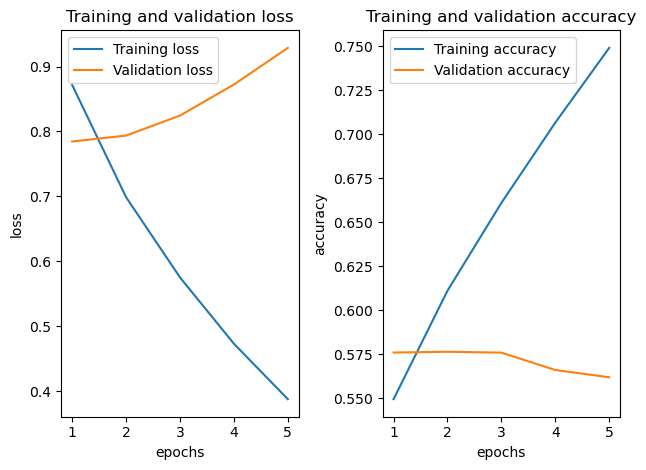

The best epoch is 2


W0000 00:00:1723044224.952225   17618 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1723044482.532171   17618 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1723044558.035285   14356 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1723044565.304360   14359 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 1884 bytes spill stores, 1880 bytes spill loads

I0000 00:00:1723044666.473497   17618 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_244__3', 20 bytes spill stores, 20 bytes spill loads



In [ ]:
BATCH_SIZE = 8

for learning_rate in [1e-5, 5e-6, 1e-6]:
    bart_lm, filepath, history = build_bart_model(
        training_data=train_ds,
        validation_data=validation_ds,
        learning_rate=learning_rate,
        epochs=20,
        is_saved=False,
    )
    plot(history=history, keys=["loss", "accuracy"])


### Note (Experiment Date: 2024-08-02 13:52:00~)

- BART with pretrained model

#### Result

- Unexpectedly, `bart_base_en` model marked slightly better ROUGE score.

_ | ROUGE-1 | ROUGE-2 | ROUGE-L
--- | --- | --- | ---
bart_large_en | 39.6 | 16.2 | 31.4
bart_large_en_cnn | 41.2 | 16.7 | 33.1
bart_base_en | 42.1 | 18.1 | 34.3

#### Next

- Calculate each ROUGE score for every epoch because it is not always that the highest accuracy or the least loss makes the best ROUGE.
- Parameter-tuning of optimizer, even though it seems hard to improve the ROUGE score because training did not improve the validation loss and accuracy.
- Bare Transformer model with the best number of epochs.

#### bart_large_en

In [15]:
BATCH_SIZE = 8

bart_lm, filepath, history = build_bart_model(
    training_data=train_ds,
    validation_data=validation_ds,
    preset_name="bart_large_en",
    is_saved=False,
)
plot(history=history, keys=["loss", "accuracy"])

best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_accuracy"]))
best_epoch = best_epoch + 1
print("The best epoch is", best_epoch)
bart_lm, filepath, _ = build_bart_model(
    training_data=train_ds.concatenate(validation_ds),
    validation_data=None,
    epochs=best_epoch,
    preset_name="bart_large_en",
    verbose=0,
    is_saved=False,
)

Preprocessor: "bart_seq2_seq_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bart_tokenizer (BartTokenizer)                     │                                              50,265 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bart_seq2_seq_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ decoder_padding_mask          │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder_token_ids             │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_padding_mask          │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_token_ids             │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bart_backbone (BartBackbone)  │ [(None, None, 1024),      │     406,287,360 │ decoder_padding_mask[0][0… │
│                               │ (None, None, 1024)]       │                 │ decoder_token_ids[0][0],   │
│                               │                           │                 │ encoder_padding_mask[0][0… │
│                               │                           │                 │ encoder_token_ids[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 50265)       │      51,471,360 │ bart_backbone[0][0]        │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 406,287,360 (1.51 GB)

 Trainable params: 406,287,360 (1.51 GB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


2024-08-08 12:34:25.329588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 269/1842 ━━━━━━━━━━━━━━━━━━━━ 1:12:10 3s/step - accuracy: 0.5441 - loss: 0.8803

KeyboardInterrupt: 

In [ ]:
dialogue, y_true, y_pred = generate_prediction_result(
    bart_lm=bart_lm,
    ds=test_ds.map(format_dataset_bart_seq2seq),
    max_length=DECODER_SEQUENCE_LENGTH
)
display_sampled_summary(
    x=dialogue,
    y_true=y_true,
    y_pred=y_pred
)

Dialogue: b"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him \xf0\x9f\x99\x82\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"
Generated Summary: Betty's number is not in Amanda's possession and Hannah will ask Larry if she could get it for Betty. Hannah is not sure about Betty. Hannah will let Amanda know when she can talk with her. Hannah will text him about the situation.
Ground Truth Summary: b"Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry."
Dialogue: b"Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric: I know! And shows how Americans see Russian ;)\r\nRob: And it's really funny!\r\nEric: I know! I especially like the train part!\r\

In [ ]:
calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred
)

({'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.4121847>,
  'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.44109234>,
  'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.39567354>},
 {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.1710483>,
  'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.18096353>,
  'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.16223642>},
 {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.32824823>,
  'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.35013813>,
  'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.31380486>})

#### bart_large_en_cnn

Preprocessor: "bart_seq2_seq_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bart_tokenizer (BartTokenizer)                     │                                              50,265 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bart_seq2_seq_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ decoder_padding_mask          │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder_token_ids             │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_padding_mask          │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_token_ids             │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bart_backbone (BartBackbone)  │ [(None, None, 1024),      │     406,286,336 │ decoder_padding_mask[0][0… │
│                               │ (None, None, 1024)]       │                 │ decoder_token_ids[0][0],   │
│                               │                           │                 │ encoder_padding_mask[0][0… │
│                               │                           │                 │ encoder_token_ids[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 50264)       │      51,470,336 │ bart_backbone[0][0]        │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 406,286,336 (1.51 GB)

 Trainable params: 406,286,336 (1.51 GB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


I0000 00:00:1723039751.564694   17621 service.cc:145] XLA service 0x7feaac012e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723039751.564836   17621 service.cc:153]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-08-07 14:09:14.493745: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1723039756.114154   17621 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-08-07 14:09:29.662078: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1723039899.313737   19539 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_739', 452 bytes spill stores, 700 bytes spill loads

I0000 00:00:1723

1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.5682 - loss: 0.8171

W0000 00:00:1723040405.032939   17621 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1723040556.522585   27612 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_198', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1723040557.146435   27613 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_810', 452 bytes spill stores, 700 bytes spill loads

I0000 00:00:1723040558.922157   27617 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_314', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1723040562.586773   27617 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_763', 452 bytes spill stores, 700 bytes spill loads

I0000 00:00:1723040562.883024   27616 


1842/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.5682 - loss: 0.8171

W0000 00:00:1723040866.679881   17617 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1723040874.151060   17621 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1723040877.936740     803 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_278', 452 bytes spill stores, 700 bytes spill loads

I0000 00:00:1723040880.270306     801 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_231', 452 bytes spill stores, 700 bytes spill loads

I0000 00:00:1723040885.594276     798 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_192', 1884 bytes spill stores, 1880 bytes spill loads



1842/1842 ━━━━━━━━━━━━━━━━━━━━ 1253s 387ms/step - accuracy: 0.5682 - loss: 0.8171 - val_accuracy: 0.5757 - val_loss: 0.7771
Epoch 2/5
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 227s 122ms/step - accuracy: 0.6421 - loss: 0.6159 - val_accuracy: 0.5651 - val_loss: 0.7857
Epoch 3/5
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 227s 122ms/step - accuracy: 0.7067 - loss: 0.4662 - val_accuracy: 0.5645 - val_loss: 0.8564
Epoch 4/5
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 232s 124ms/step - accuracy: 0.7625 - loss: 0.3580 - val_accuracy: 0.5440 - val_loss: 0.9714
Epoch 5/5
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 229s 123ms/step - accuracy: 0.8064 - loss: 0.2773 - val_accuracy: 0.5487 - val_loss: 1.0180
0.7771388292312622 The best number of epocs for the validation loss is 1
0.5757169723510742 The best number of epocs for the validation accuracy is 1


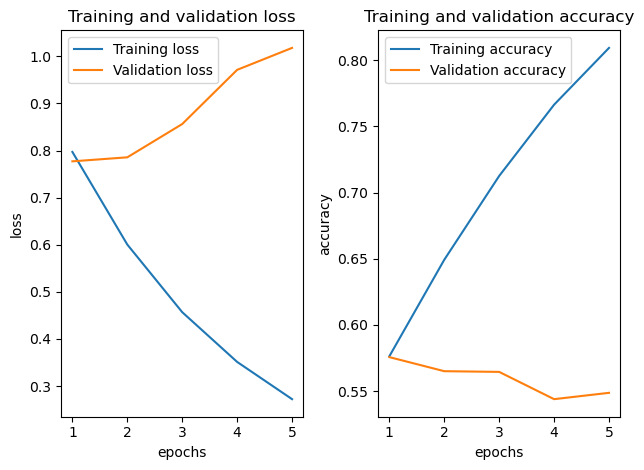

The best epoch is 1


W0000 00:00:1723041939.068717   17620 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1723042571.643959   17620 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1723042718.712457   22462 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_198', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1723042720.306850   22456 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_810', 452 bytes spill stores, 700 bytes spill loads

I0000 00:00:1723042721.355270   22462 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_763', 452 bytes spill stores, 700 bytes spill loads

I0000 00:00:1723042721.829958   22457 a

In [ ]:
BATCH_SIZE = 8

bart_lm, filepath, history = build_bart_model(
    training_data=train_ds,
    validation_data=validation_ds,
    preset_name="bart_large_en_cnn",
    is_saved=False,
)
plot(history=history, keys=["loss", "accuracy"])

best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_accuracy"]))
best_epoch = best_epoch + 1
print("The best epoch is", best_epoch)
bart_lm, filepath, _ = build_bart_model(
    training_data=train_ds.concatenate(validation_ds),
    validation_data=None,
    epochs=best_epoch,
    preset_name="bart_large_en_cnn",
    verbose=0,
    is_saved=False,
)

In [ ]:
dialogue, y_true, y_pred = generate_prediction_result(
    bart_lm=bart_lm,
    ds=test_ds.map(format_dataset_bart_seq2seq),
    max_length=DECODER_SEQUENCE_LENGTH
)
display_sampled_summary(
    x=dialogue,
    y_true=y_true,
    y_pred=y_pred
)

Dialogue: b"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him \xf0\x9f\x99\x82\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"
Generated Summary: Hannah is looking for Betty's number. Amanda will text Larry. Hannah has a cold.
Ground Truth Summary: b"Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry."
Dialogue: b"Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric: I know! And shows how Americans see Russian ;)\r\nRob: And it's really funny!\r\nEric: I know! I especially like the train part!\r\nRob: Hahaha! No one talks to the machine like that!\r\nEric: Is this his only stand-up?\r\nRob: Idk. I'll check.\r\nEric: Sure.\r\nRob: Turns out no! 

In [ ]:
calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred
)

({'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.45377052>,
  'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.43094596>,
  'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.41213316>},
 {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.18619569>,
  'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.175663>,
  'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.16733189>},
 {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.36458507>,
  'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.3471443>,
  'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.33139962>})

#### bart_base_en

100%|██████████| 141/141 [00:00<00:00, 267kB/s]


100%|██████████| 448/448 [00:00<00:00, 1.87MB/s]


100%|██████████| 0.99M/0.99M [00:01<00:00, 884kB/s]


100%|██████████| 446k/446k [00:00<00:00, 491kB/s]


100%|██████████| 483/483 [00:00<00:00, 948kB/s]


100%|██████████| 532M/532M [00:25<00:00, 22.0MB/s] 


Preprocessor: "bart_seq2_seq_lm_preprocessor_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ bart_tokenizer (BartTokenizer)                     │                                              50,265 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "bart_seq2_seq_lm_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ decoder_padding_mask          │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ decoder_token_ids             │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_padding_mask          │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ encoder_token_ids             │ (None, None)              │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bart_backbone (BartBackbone)  │ [(None, None, 768),       │     139,417,344 │ decoder_padding_mask[0][0… │
│                               │ (None, None, 768)]        │                 │ decoder_token_ids[0][0],   │
│                               │                           │                 │ encoder_padding_mask[0][0… │
│                               │                           │                 │ encoder_token_ids[0][0]    │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 50265)       │      38,603,520 │ bart_backbone[0][0]        │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 139,417,344 (531.83 MB)

 Trainable params: 139,417,344 (531.83 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


W0000 00:00:1723043218.172744   17618 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1723043292.824088   30899 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1723043300.536645   30900 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 1884 bytes spill stores, 1880 bytes spill loads

I0000 00:00:1723043396.629483   17618 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_227__3', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_30', 4 bytes spill stores, 4 bytes spill loads



1841/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5366 - loss: 0.9073

W0000 00:00:1723043496.547310   17621 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1723043578.554509    1931 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1723043586.128558    1928 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 1884 bytes spill stores, 1880 bytes spill loads

I0000 00:00:1723043685.974172   17621 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_636__4', 156 bytes spill stores, 156 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_256__3', 16 bytes spill stores, 16 bytes spill loads




1842/1842 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.5366 - loss: 0.9073

W0000 00:00:1723043697.963411   17620 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1723043702.376123   17623 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1723043708.325045    4503 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1723043712.422581    4505 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 1884 bytes spill stores, 1880 bytes spill loads



1842/1842 ━━━━━━━━━━━━━━━━━━━━ 560s 174ms/step - accuracy: 0.5366 - loss: 0.9073 - val_accuracy: 0.5760 - val_loss: 0.7845
Epoch 2/5
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 110s 58ms/step - accuracy: 0.6037 - loss: 0.7151 - val_accuracy: 0.5764 - val_loss: 0.7936
Epoch 3/5
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 108s 58ms/step - accuracy: 0.6543 - loss: 0.5870 - val_accuracy: 0.5759 - val_loss: 0.8245
Epoch 4/5
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 107s 57ms/step - accuracy: 0.7022 - loss: 0.4822 - val_accuracy: 0.5661 - val_loss: 0.8723
Epoch 5/5
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 107s 57ms/step - accuracy: 0.7452 - loss: 0.3946 - val_accuracy: 0.5620 - val_loss: 0.9287
0.7845414876937866 The best number of epocs for the validation loss is 1
0.5764316916465759 The best number of epocs for the validation accuracy is 2


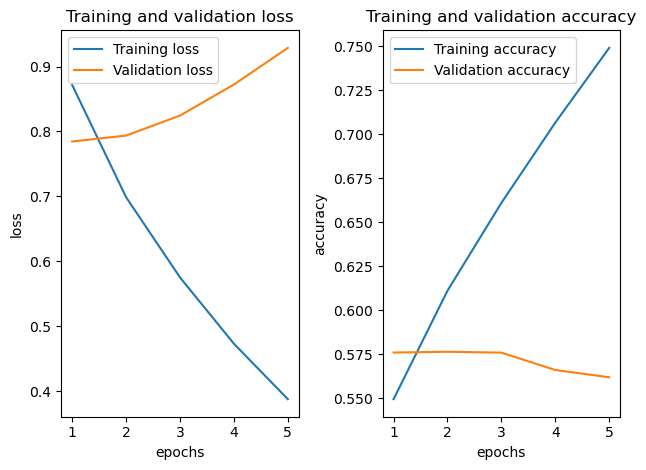

The best epoch is 2


W0000 00:00:1723044224.952225   17618 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1723044482.532171   17618 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1723044558.035285   14356 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1723044565.304360   14359 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_96', 1884 bytes spill stores, 1880 bytes spill loads

I0000 00:00:1723044666.473497   17618 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_244__3', 20 bytes spill stores, 20 bytes spill loads



In [ ]:
BATCH_SIZE = 8

bart_lm, filepath, history = build_bart_model(
    training_data=train_ds,
    validation_data=validation_ds,
    is_saved=False,
)
plot(history=history, keys=["loss", "accuracy"])

best_epoch = max(np.argmin(history.history[f"val_loss"]), np.argmax(history.history[f"val_accuracy"]))
best_epoch = best_epoch + 1
print("The best epoch is", best_epoch)
bart_lm, filepath, _ = build_bart_model(
    training_data=train_ds.concatenate(validation_ds),
    validation_data=None,
    epochs=best_epoch,
    verbose=0,
    is_saved=False,
)

In [ ]:
dialogue, y_true, y_pred = generate_prediction_result(
    bart_lm=bart_lm,
    ds=test_ds.map(format_dataset_bart_seq2seq),
    max_length=DECODER_SEQUENCE_LENGTH
)
display_sampled_summary(
    x=dialogue,
    y_true=y_true,
    y_pred=y_pred
)

Dialogue: b"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him \xf0\x9f\x99\x82\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"
Generated Summary: Hannah can't find Betty's number, because she called Larry last time they were at the park together. Amanda suggests to text Larry instead of using Facebook.
Ground Truth Summary: b"Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry."
Dialogue: b"Eric: MACHINE!\r\nRob: That's so gr8!\r\nEric: I know! And shows how Americans see Russian ;)\r\nRob: And it's really funny!\r\nEric: I know! I especially like the train part!\r\nRob: Hahaha! No one talks to the machine like that!\r\nEric: Is this his 

In [ ]:
calculate_rouge_score(
    y_true=y_true,
    y_pred=y_pred
)

({'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.44864184>,
  'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.44959518>,
  'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.42114675>},
 {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.19555798>,
  'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.19434093>,
  'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.18135415>},
 {'precision': <tf.Tensor: shape=(), dtype=float32, numpy=0.36647415>,
  'recall': <tf.Tensor: shape=(), dtype=float32, numpy=0.36553767>,
  'f1_score': <tf.Tensor: shape=(), dtype=float32, numpy=0.34278908>})